In [2]:
!pip install optuna

In [3]:
import optuna
from transformers import BertForSequenceClassification
import torch
import torch.optim as optim
import torch.nn as nn
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import f1_score
import json
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score



                                                text  label
0   His final gambit, a symphony of silence perme...      0
1   The illustrious career of our protagonist met...      0
2   The townsfolk slept, oblivious to the unfoldi...      1
3   This once-simple farmer had transformed into ...      1
4   His relentless pursuit of righting the wrong ...      1


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Loss: 0.5887
Epoch 2, Loss: 0.2465
Epoch 3, Loss: 0.1743
Epoch 4, Loss: 0.0359
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.81      0.80        59
           1       0.82      0.79      0.80        62

    accuracy                           0.80       121
   macro avg       0.80      0.80      0.80       121
weighted avg       0.80      0.80      0.80       121



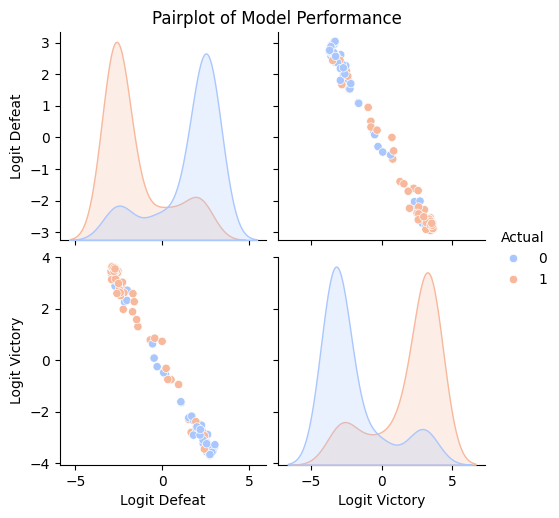

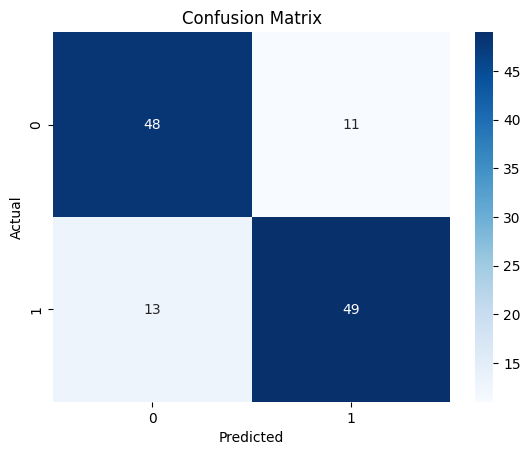

In [4]:

# Load dataset
with open("stories.json", "r") as f:
    data = json.load(f)

stories = data["stories"]
final_sentence = [story["story"].split(".")[-2] for story in stories]  # Extracting the last sentence from each story
labels = [1 if story["outcome"] == "victory" else 0 for story in stories]  # Encode labels for victory and defeat

df = pd.DataFrame({"text": final_sentence, "label": labels})
print(df.head())

# Initializing tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

class StoryDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Splitting the data into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(df["text"], df["label"], test_size=0.2, random_state=42)

train_dataset = StoryDataset(train_texts.tolist(), train_labels.tolist(), tokenizer)
test_dataset = StoryDataset(test_texts.tolist(), test_labels.tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Loading pre-trained BERT model
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)

# Set up optimizer and loss function
opti = optim.AdamW(bert_model.parameters(), lr=5e-5)
criteria = nn.CrossEntropyLoss()

# Training loop
def training(model, train_loader, optimizer, criterion, epochs=4):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

training(bert_model, train_loader, opti, criteria)

# Evaluating the model
def evaluate(model, test_loader):
    model.eval()
    predictions, actuals, logits_list = [], [], []

    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)

            logits = outputs.logits.cpu().numpy()
            preds = np.argmax(logits, axis=1)

            predictions.extend(preds)
            actuals.extend(labels.cpu().numpy())
            logits_list.extend(logits)

    print("Classification Report:\n", classification_report(actuals, predictions))
    return actuals, predictions, logits_list

actuals, predictions, logits_list = evaluate(bert_model, test_loader)

logits_df = pd.DataFrame(logits_list, columns=["Logit Defeat", "Logit Victory"])
logits_df["Actual"] = actuals


# Pairplot visualization
sns.pairplot(logits_df, hue="Actual", diag_kind="kde", vars=["Logit Defeat", "Logit Victory"], palette="coolwarm")
plt.suptitle("Pairplot of Model Performance", y=1.02)
plt.show()

# Confusion Matrix
sns.heatmap(pd.crosstab(pd.Series(actuals, name="Actual"), pd.Series(predictions, name="Predicted")), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


Hyperparameter Tuning

[I 2025-03-03 03:56:39,798] A new study created in memory with name: no-name-fa0ed78e-2379-4c79-af73-04986e597c04
<ipython-input-9-25ee72c9d571>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lr', 1e-6, 5e-4)
<ipython-input-9-25ee72c9d571>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictio

Trial 0: Accuracy = 0.5041, F1-score = 0.0909, LR = 1.4647824517360718e-06, Batch Size = 32, Epochs = 3, Weight Decay = 6.7221420957629636e-06


<ipython-input-9-25ee72c9d571>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lr', 1e-6, 5e-4)
<ipython-input-9-25ee72c9d571>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-03-03 03:58:09,596] Trial 1 finished with value: 0.7758620689655172 and parameters: {'lr

Trial 1: Accuracy = 0.7851, F1-score = 0.7759, LR = 4.968508954386335e-06, Batch Size = 8, Epochs = 5, Weight Decay = 8.083817250242532e-05


<ipython-input-9-25ee72c9d571>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lr', 1e-6, 5e-4)
<ipython-input-9-25ee72c9d571>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-03-03 03:58:29,526] Trial 2 finished with value: 0.7878787878787878 and parameters: {'lr

Trial 2: Accuracy = 0.7686, F1-score = 0.7879, LR = 8.128632489029188e-05, Batch Size = 64, Epochs = 2, Weight Decay = 0.0003012084319814903


<ipython-input-9-25ee72c9d571>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lr', 1e-6, 5e-4)
<ipython-input-9-25ee72c9d571>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-03-03 03:59:22,199] Trial 3 finished with value: 0.0 and parameters: {'lr': 0.0002455066

Trial 3: Accuracy = 0.4876, F1-score = 0.0000, LR = 0.0002455066032173144, Batch Size = 16, Epochs = 5, Weight Decay = 0.0006965823332134827


<ipython-input-9-25ee72c9d571>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lr', 1e-6, 5e-4)
<ipython-input-9-25ee72c9d571>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-03-03 03:59:54,426] Trial 4 finished with value: 0.8805970149253731 and parameters: {'lr

Trial 4: Accuracy = 0.8678, F1-score = 0.8806, LR = 1.88465695878293e-05, Batch Size = 16, Epochs = 3, Weight Decay = 3.0875452496946693e-06


<ipython-input-9-25ee72c9d571>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lr', 1e-6, 5e-4)
<ipython-input-9-25ee72c9d571>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-03-03 04:00:33,359] Trial 5 finished with value: 0.8245614035087719 and parameters: {'lr

Trial 5: Accuracy = 0.8347, F1-score = 0.8246, LR = 8.867963030656438e-05, Batch Size = 32, Epochs = 4, Weight Decay = 0.00020074070873922015


<ipython-input-9-25ee72c9d571>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lr', 1e-6, 5e-4)
<ipython-input-9-25ee72c9d571>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-03-03 04:01:09,110] Trial 6 finished with value: 0.4634146341463415 and parameters: {'lr

Trial 6: Accuracy = 0.6364, F1-score = 0.4634, LR = 9.390294491798798e-05, Batch Size = 8, Epochs = 3, Weight Decay = 0.0022057935326109212


<ipython-input-9-25ee72c9d571>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lr', 1e-6, 5e-4)
<ipython-input-9-25ee72c9d571>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-03-03 04:01:28,820] Trial 7 finished with value: 0.0 and parameters: {'lr': 0.0004274895

Trial 7: Accuracy = 0.4876, F1-score = 0.0000, LR = 0.00042748958660877796, Batch Size = 64, Epochs = 2, Weight Decay = 0.0005986094664663964


<ipython-input-9-25ee72c9d571>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lr', 1e-6, 5e-4)
<ipython-input-9-25ee72c9d571>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-03-03 04:01:48,575] Trial 8 finished with value: 0.18666666666666668 and parameters: {'l

Trial 8: Accuracy = 0.4959, F1-score = 0.1867, LR = 2.7705785304056056e-06, Batch Size = 64, Epochs = 2, Weight Decay = 2.877306283586267e-06


<ipython-input-9-25ee72c9d571>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lr', 1e-6, 5e-4)
<ipython-input-9-25ee72c9d571>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-03-03 04:02:08,682] Trial 9 finished with value: 0.7870967741935484 and parameters: {'lr

Trial 9: Accuracy = 0.7273, F1-score = 0.7871, LR = 4.470384179184187e-05, Batch Size = 32, Epochs = 2, Weight Decay = 8.774928990039857e-05
Best Hyperparameters: {'lr': 1.88465695878293e-05, 'batch_size': 16, 'epochs': 3, 'weight_decay': 3.0875452496946693e-06}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Loss: 0.6763
Epoch 2, Loss: 0.4675
Epoch 3, Loss: 0.1886
Best Model Accuracy: 0.8017, F1-score: 0.7931


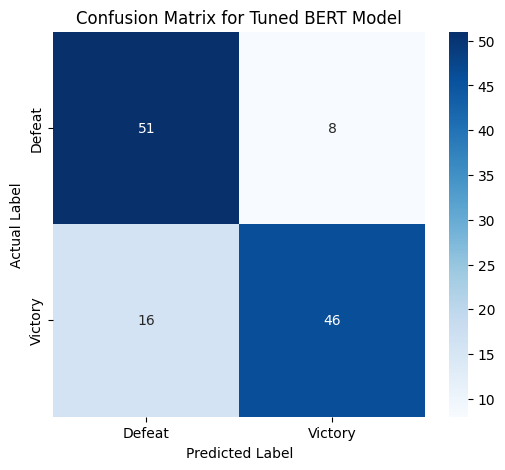

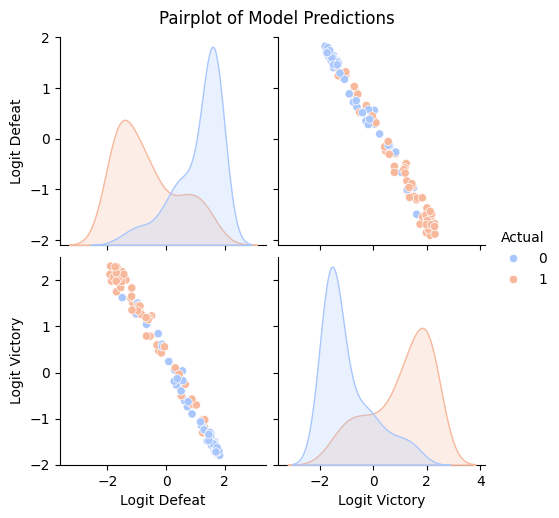

In [9]:
# Function to evaluate the model
def evaluate_tuned_model(model, test_loader):
    model.eval()
    predictions, actuals, logits_list = [], [], []

    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)

            logits = outputs.logits.cpu().numpy()
            preds = np.argmax(logits, axis=1)

            predictions.extend(preds)
            actuals.extend(labels.cpu().numpy())
            logits_list.extend(logits)

    accuracy = accuracy_score(actuals, predictions)
    f1 = f1_score(actuals, predictions)

    return accuracy, f1, actuals, predictions, logits_list

# Optuna objective function
def optuna_objective(trial):
    learning_rate = trial.suggest_loguniform('lr', 1e-6, 5e-4)
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32, 64])
    num_epochs = trial.suggest_int('epochs', 2, 5)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)

    # DataLoader with tuned batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Load model
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).to(device)

    # Optimizer with weight decay
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    # Training loop
    model.train()
    for epoch in range(num_epochs):
        for batch in train_loader:
            input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()

    # Evaluating model
    accuracy, f1, _, _, _ = evaluate_tuned_model(model, test_loader)

    print(f"Trial {trial.number}: Accuracy = {accuracy:.4f}, F1-score = {f1:.4f}, LR = {learning_rate}, Batch Size = {batch_size}, Epochs = {num_epochs}, Weight Decay = {weight_decay}")

    return f1

# Run Optuna optimization and retrieve the best trial's parameters
study = optuna.create_study(direction="maximize")
study.optimize(optuna_objective, n_trials=10)

# Fetch the best parameters from the study
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Initialize the best model with optimal parameters (best trial)
best_bert_model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2
).to(device)

# DataLoader with the best batch size from the best trial
train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'], shuffle=False)

# Optimizer and Loss function with best trial's hyperparameters
optimizer = optim.AdamW(best_bert_model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
criterion = nn.CrossEntropyLoss()

# Training the model with the best hyperparameters
def training_best_model(model, train_loader, optimizer, criterion, num_epochs=best_params['epochs']):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in train_loader:
            input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader):.4f}")

# Train the model using the best parameters
training_best_model(best_bert_model, train_loader, optimizer, criterion)

# Evaluate the best model (with the best hyperparameters)
accuracy, f1, actuals, predictions, logits_list = evaluate_tuned_model(best_bert_model, test_loader)
print(f"Best Model Accuracy: {accuracy:.4f}, F1-score: {f1:.4f}")

# Create DataFrame of logits for visualization
logits_df = pd.DataFrame(logits_list, columns=["Logit Defeat", "Logit Victory"])
logits_df["Actual"] = actuals

# Confusion Matrix visualization
cm = confusion_matrix(actuals, predictions)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Defeat", "Victory"], yticklabels=["Defeat", "Victory"])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix for Tuned BERT Model")
plt.show()

# Pairplot visualization for logits
sns.pairplot(logits_df, hue="Actual", diag_kind="kde", vars=["Logit Defeat", "Logit Victory"], palette="coolwarm")
plt.suptitle("Pairplot of Model Predictions", y=1.02)
plt.show()


tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

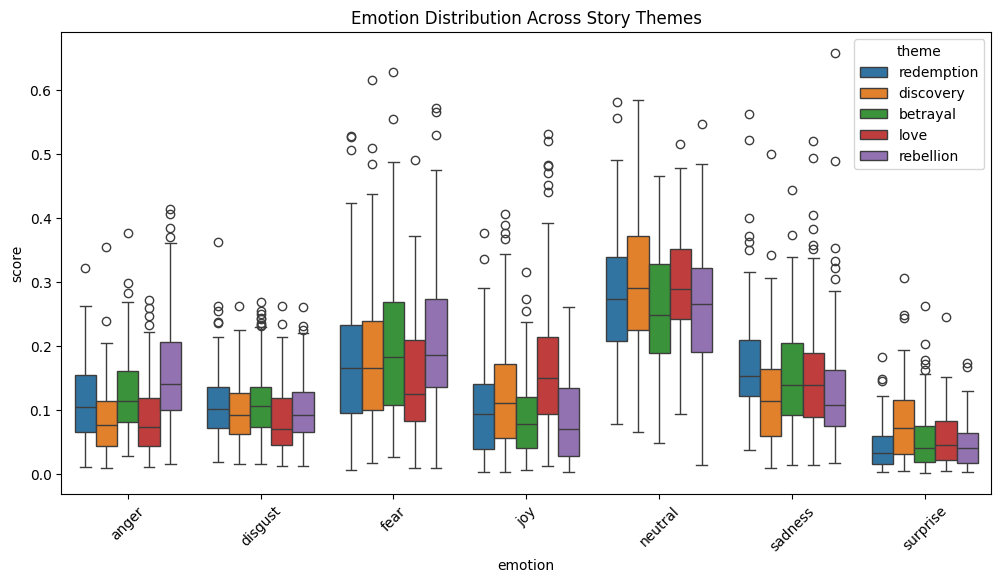

In [7]:
stories = data["stories"]

# Extract sentences and themes
sentences = []
themes = []
story_indices = []

for story in stories:
    story_text = story["story"].split(". ")  # Split into sentences
    for sentence in story_text:
        sentences.append(sentence)
        themes.append(story["theme"])
        story_indices.append(story["index"])

df = pd.DataFrame({"sentence": sentences, "theme": themes, "story_index": story_indices})

# Load pre-trained emotion detection model
tokenizer = AutoTokenizer.from_pretrained("j-hartmann/emotion-english-distilroberta-base")
model = AutoModelForSequenceClassification.from_pretrained("j-hartmann/emotion-english-distilroberta-base")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Emotion classification dataset
class EmotionDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
        }

# Create dataset and dataloader
dataset = EmotionDataset(df["sentence"].tolist(), tokenizer)
dataloader = DataLoader(dataset, batch_size=8, shuffle=False)

# Get emotion probability distributions
emotion_probs = []
model.eval()
with torch.no_grad():
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        probs = F.softmax(outputs.logits, dim=-1).cpu().numpy()
        emotion_probs.extend(probs)

# Convert to DataFrame
emotion_labels = ["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"]
emotion_df = pd.DataFrame(emotion_probs, columns=emotion_labels)
df = pd.concat([df, emotion_df], axis=1)

# Aggregate emotions per story
story_emotions = df.groupby("story_index")[emotion_labels].mean()
story_emotions["theme"] = df.groupby("story_index")["theme"].first()

# Visualization: Emotion distribution across themes
plt.figure(figsize=(12, 6))
sns.boxplot(data=story_emotions.melt(id_vars=["theme"], var_name="emotion", value_name="score"), x="emotion", y="score", hue="theme")
plt.title("Emotion Distribution Across Story Themes")
plt.xticks(rotation=45)
plt.show()

# Save processed data
story_emotions.to_csv("story_emotion_analysis.csv", index=False)
